In [1]:
rm(list=ls())
library(caTools)
library(ggplot2)
library('mlbench')
library("scatterplot3d")

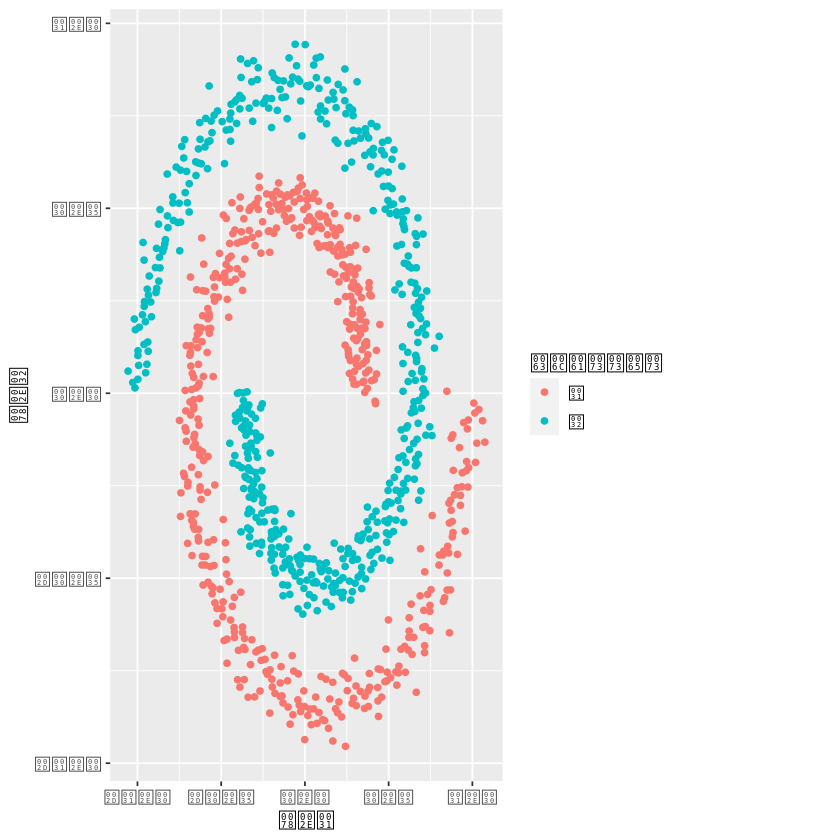

In [2]:
spirals = mlbench.spirals(1000,1,0.05)
spirals2 = data.frame(spirals)
amostra = matrix(unlist(spirals$x), ncol = 2)
classeAmost = matrix(unlist(spirals$classes))
ggplot(data = spirals2, aes (x.1, x.2,color=classes)) + geom_point()


In [3]:
generateCentro <- function(k){
    centro = matrix(0, ncol = 2, nrow=k)
    for(i in 1:k){
        centro[i,]= rnorm(2, mean=runif(1,-1,1), sd=0.3)
    }
    return(centro)
}
clusters <- function(X,p,centro){
    dims = dim(X)[1]
    pos = 1
    classe = matrix(0, ncol = 1, nrow = dims)
    qtdCentro <- dim(centro)[1]
    dist = matrix(0, nrow=qtdCentro)
    for(i in 1:dims){
        for(j in 1:qtdCentro){
            dist[j] = dist_Manhattan(p, X[i,],centro[j,] )
            
        }
        p = match(min(dist),dist)
        

        classe[i] = p
        
    }
    
    for(t in 1: qtdCentro){
        if(sum(classe == t) == 0){
            random = as.integer(runif(1,1,dims))
            classe[random] = t
        }
    }
    
    return(classe)
    
}

updateValueCenter <- function(classe,X,k){
    row = dim(classe)[1]
    
    centro = matrix(0, nrow = k, ncol=2)
    qtd = matrix(0, nrow=k)
    
    for(i in 1:row){
        for(j in 1:k){
           qtd[j] = sum(classe==j)
            
            if(classe[i] == (j)){
                centro[j,1] = centro[j,1] + X[i,1]
                centro[j,2] = centro[j,2] + X[i,2]
            }
            
        }
          
    }
    
    for(j in 1:k){
        centro[j,1] =  centro[j,1]/ qtd[j]
        centro[j,2] =  centro[j,2]/ qtd[j]
        
    }
    
    return(centro)
    
    
}

getColors <- function(classe,k){
    color = rainbow(k)
    row = dim(classe)[1]
    colors = matrix('', ncol = row)
    for(i in 1:row){
        for(j in 1:k){
           if(classe[i] == j){
                colors[i] = color[j]
            }
        }
   
    }
    return(colors)
}

dist_Manhattan <- function(p,x,centro){
    dist = 0
    
    dist = (x[1] - centro[1])^p + (x[2] - centro[2])^p
    dist= abs(dist) ^ (1/p)  
            
    return(dist)
}

funcaoProbabilidade <- function(x1,x2,h1,h2,xu1, xu2,N){
    
    A = 1/(N*(sqrt(2*pi)*h1)^2)
    
    B = -((x1 - xu1)^2)/(2*h1^2)
    C =  -((x2 - xu2)^2)/(2*h1^2)
    
    
    D = A*(exp(B) * exp(C))
    
    return(D)
}


In [4]:
validacaoCruzada <- function(X,Y,k,sample,t){
    dims = dim(X)[1]/t
    X_test = X[sample[((k-1)*dims + 1):(k*dims)],]
    Y_test = Y[sample[((k-1)*dims + 1):(k*dims)]]
    
    X_train = X[-sample[((k-1)*dims + 1):(k*dims)],]
    Y_train = Y[-sample[((k-1)*dims + 1):(k*dims)]]
    
    
    return(list(X_train = X_train,Y_train = Y_train, X_test = X_test,Y_test= Y_test))
     
}

In [5]:
qtd = 100
test = matrix(0, nrow= qtd^2, ncol=2)
vectorX = seq(-1, 1, len=qtd)
vectorY = seq(-1, 1, len=qtd)
count = 0
for(i in 1:qtd){
    for(j in 1:qtd){
        count = count + 1
        test[count,1] = vectorX[i]
        test[count,2] = vectorY[j]
    
    }
  
}

In [6]:
sampleA = sample(1000)

In [24]:

validacao = 20
vetorAcuracia = matrix(0, nrow= validacao)

for(i in 1:validacao){
    saida = validacaoCruzada(amostra,classeAmost,i,sampleA,validacao)
    
    X_test = saida$X_test
    Y_test = saida$Y_test
    X_train = saida$X_train
    Y_train = saida$Y_train
    
    PC1  = (dim(X_train[Y_train==1,])[1])/(dim(X_train[Y_train==1,])[1] + dim(X_train[Y_train==2,])[1])
    PC2  = (dim(X_train[Y_train==2,])[1])/(dim(X_train[Y_train==1,])[1] + dim(X_train[Y_train==2,])[1])
    
    N = nrow(X_train)
    X_trainC1 = X_train[Y_train == 1,]
    X_trainC2 = X_train[Y_train == 2,]
    
    h1 = (1.06* sd(X_trainC1) *N)^(-1/5)
    
    h2 = (1.06*sd(X_trainC2)*N)^(-1/5)
    
    
    probC1 = matrix(0, nrow = nrow(X_test))
    probC2 = matrix(0, nrow = nrow(X_test))
    classeAprox = matrix(0, nrow = nrow(X_test))
    
    for(j in 1:nrow(X_test)){
        
        for(k in 1:nrow(X_trainC1)){
            probC1[j] = probC1[j] + funcaoProbabilidade(X_trainC1[k,1],X_trainC1[k,2],h1,h1,X_test[j,1], X_test[j,2],N) 

        }
        
        for(k in 1:nrow(X_trainC2)){
            probC2[j] = probC2[j] + funcaoProbabilidade(X_trainC2[k,1],X_trainC2[k,2],h2,h2,X_test[j,1], X_test[j,2],N)
            
        }
        
        
        K = (probC1[j] *PC1)/(probC2[j] *PC2)
        if(K >= 1){
          classeAprox[j] = 1  
        }else{
            classeAprox[j] = 2
        }
        
        
    }
    cmTest = as.matrix(table(Actual = Y_test, Predicted = classeAprox)) # create the confusion matrix
    n = sum(cmTest)
    diag = diag(cmTest)
    vetorAcuracia[i] = sum(diag) / n
    
    print(paste('Validacao cruzada folder=',i,' Acuracia:',vetorAcuracia[i]))
    
} 


[1] "Validacao cruzada folder= 1  Acuracia: 0.94"
[1] "Validacao cruzada folder= 2  Acuracia: 0.92"
[1] "Validacao cruzada folder= 3  Acuracia: 0.96"
[1] "Validacao cruzada folder= 4  Acuracia: 0.98"
[1] "Validacao cruzada folder= 5  Acuracia: 1"
[1] "Validacao cruzada folder= 6  Acuracia: 0.96"
[1] "Validacao cruzada folder= 7  Acuracia: 0.96"
[1] "Validacao cruzada folder= 8  Acuracia: 0.98"
[1] "Validacao cruzada folder= 9  Acuracia: 0.94"
[1] "Validacao cruzada folder= 10  Acuracia: 0.98"
[1] "Validacao cruzada folder= 11  Acuracia: 0.98"
[1] "Validacao cruzada folder= 12  Acuracia: 0.94"
[1] "Validacao cruzada folder= 13  Acuracia: 1"
[1] "Validacao cruzada folder= 14  Acuracia: 1"
[1] "Validacao cruzada folder= 15  Acuracia: 0.98"
[1] "Validacao cruzada folder= 16  Acuracia: 1"
[1] "Validacao cruzada folder= 17  Acuracia: 0.94"
[1] "Validacao cruzada folder= 18  Acuracia: 0.98"
[1] "Validacao cruzada folder= 19  Acuracia: 0.96"
[1] "Validacao cruzada folder= 20  Acuracia: 0.98"


In [25]:
mean(vetorAcuracia)
sd(vetorAcuracia)

[1] 0.969

[1] 0.0238195

In [9]:
qtd = 100
test = matrix(0, nrow= qtd^2, ncol=2)
vectorX = seq(-1, 1, len=qtd)
vectorY = seq(-1, 1, len=qtd)
count = 0
for(i in 1:qtd){
    for(j in 1:qtd){
        count = count + 1
        test[count,1] = vectorX[i]
        test[count,2] = vectorY[j]
    
    }
  
}

In [14]:
classeAprox = matrix(0, ncol = dim(test)[1])
probC1 = matrix(1, nrow = dim(test)[1])
probC2 = matrix(1, nrow = dim(test)[1])
for(j in 1:nrow(test)){

    for(k in 1:nrow(X_trainC1)){
            probC1[j] = probC1[j] + funcaoProbabilidade(X_trainC1[k,1],X_trainC1[k,2],h1,h1,test[j,1], test[j,2],N) 

        }
        
        for(k in 1:nrow(X_trainC2)){
            probC2[j] = probC2[j] + funcaoProbabilidade(X_trainC2[k,1],X_trainC2[k,2],h1,h1,test[j,1], test[j,2],N)
            
        }
      
    K = (probC1[j] *PC1)/(probC2[j] *PC2)
    
    if(K >= 1){
      classeAprox[j] = 1  
    }else{
        classeAprox[j] = 2
    }
    
}
    


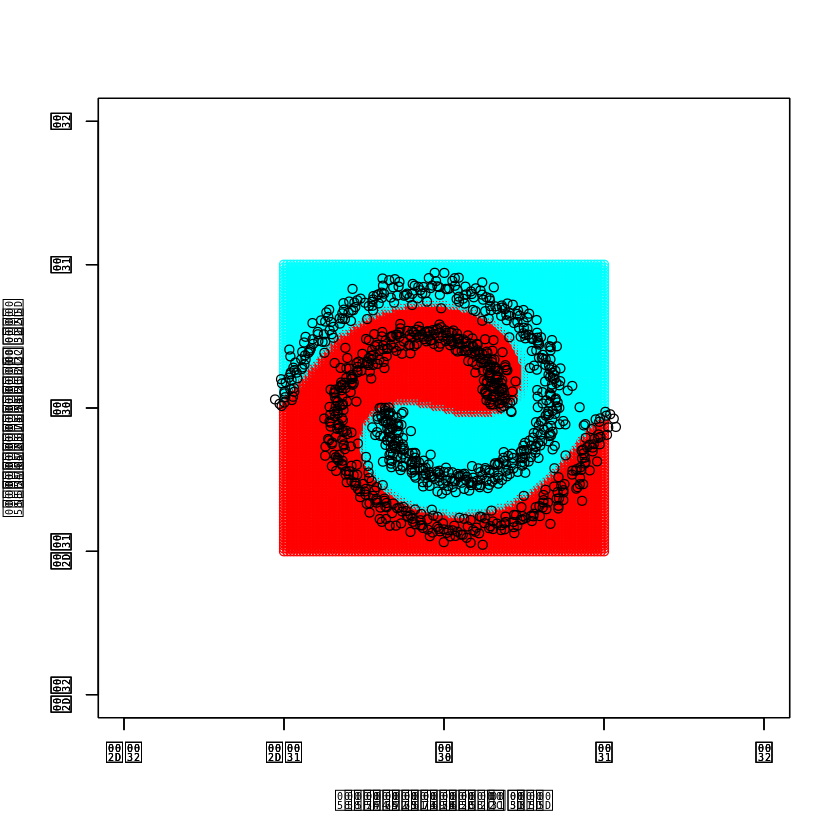

In [15]:
colors = getColors(matrix(classeAprox),2)
plot(test[,1],test[,2],xlim=c(-2,2), ylim=c(-2,2), col=colors)
par(new=TRUE)
plot(X_train[,1],X_train[,2],xlim=c(-2,2), ylim=c(-2,2), col= 'black')
par(new=TRUE)
plot(X_test[,1],X_test[,2],xlim=c(-2,2), ylim=c(-2,2), col= 'black' )

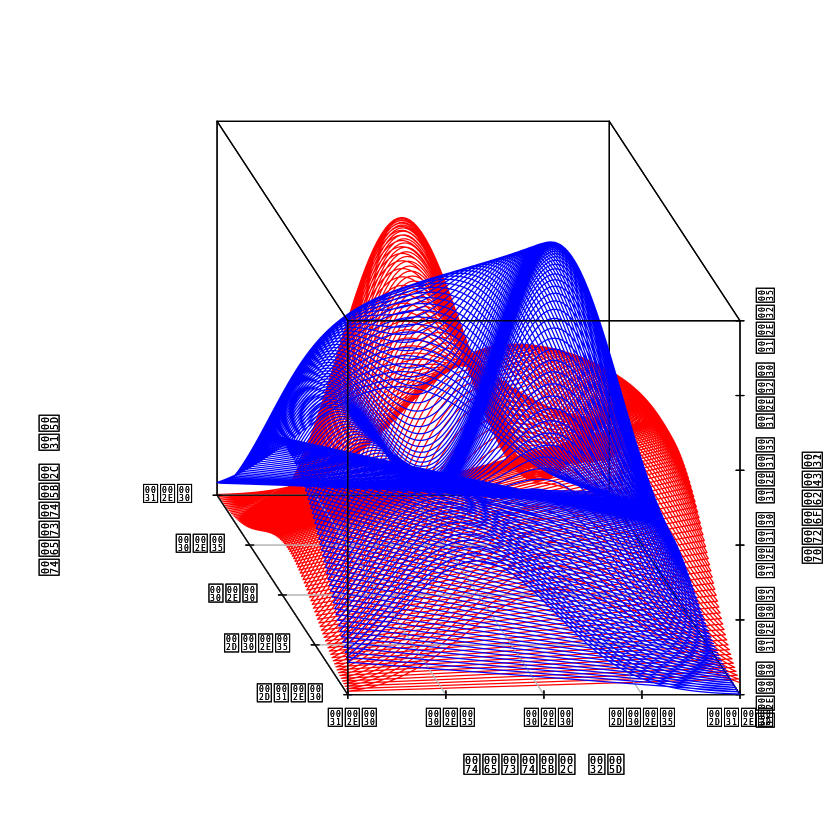

In [23]:
scatterplot3d(x = test[,1], y = test[,2], z = probC1,  angle= -60,color ='red',type = 'l')
par(new=TRUE)
scatterplot3d(x = test[,1], y = test[,2], z = probC2, angle =-60,color ='blue',type = 'l')